In [52]:
import os
import pandas as pd
import sqlite3
import json
from pydantic import BaseModel, Field
from langchain_community.tools.sql_database.tool import (
    InfoSQLDatabaseTool,
    ListSQLDatabaseTool,
    QuerySQLCheckerTool,
    QuerySQLDataBaseTool,
)
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_core.runnables import RunnableLambda
from typing import Annotated, Sequence, TypedDict
from functools import partial
import operator

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

from langgraph.graph import END, StateGraph, START

from dotenv import load_dotenv
load_dotenv(".env")

# Load environment variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# Load and prepare data
df = pd.read_csv("salary_data.csv")
connection = sqlite3.connect("salaries.db")
df.to_sql(name="salaries", con=connection, if_exists="replace")
db = SQLDatabase.from_uri("sqlite:///salaries.db")

# Initialize LLM
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.2,
    api_key=OPENAI_API_KEY
)

# Define tools
#tavily_tool = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=5)
repl = PythonREPL()

# Define agent state
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

In [53]:
# Define custom tools
@tool
def python_repl(
    code: Annotated[str, "The python code to execute for data visualization or forecasting"],
):
    """Execute python code for visualization or forecasting. Print results to show output."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

@tool("list_tables")
def list_tables() -> str:
    """List the available tables in the database"""
    return ListSQLDatabaseTool(db=db).run({})

@tool("tables_schema")
def tables_schema(tables: str) -> str:
    """
    Input is a comma-separated list of tables, output is the schema and sample rows.
    Example Input: table1, table2, table3
    """
    return InfoSQLDatabaseTool(db=db).run(tables)

@tool("execute_sql")
def execute_sql(query: str) -> str:
    """Execute a SQL query against the database and return results"""
    return QuerySQLDataBaseTool(db=db).run(query)

@tool("check_sql")
def check_sql(query: str) -> str:
    """Check if a SQL query is correct before executing it"""
    return QuerySQLCheckerTool(db=db, llm=llm).run(query)

In [54]:
# Agent creation function
def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ])
    agent = create_openai_tools_agent(llm, tools, prompt)
    return AgentExecutor(agent=agent, tools=tools, handle_parsing_errors=True)

# Agent node wrapper
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

# Define agent team
members = ["sql_agent", "data_visualizer", "forecaster", "summarizer"]
options = ["FINISH"] + members

# Custom supervisor function with improved JSON handling
def route_to_agent(state):
    messages = state["messages"]
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """
            You are an intelligent supervisor managing a team of specialists. 
            Your team includes these agents: {members}.
            
            ROUTING RULES:
            1. For database queries (counts, filters, aggregates) -> sql_agent
            2. For visualizations (charts, graphs) -> data_visualizer (but ensure sql_agent provides data first if needed)
            3. For predictions/forecasting -> forecaster (but ensure sql_agent provides time-series data first)
            4. For summarizing existing information -> summarizer
            5. When the final answer is complete -> FINISH
            
            DATA FLOW PRINCIPLES:
            - If an agent needs data but none exists in the conversation, route to sql_agent first
            - Agents can see the entire conversation history
            - Never route to the same agent twice in a row unless explicitly requested
            
            RESPONSE FORMAT:
            Respond ONLY with valid JSON containing a 'next' field, like: {{"next": "agent_name"}}
            Available options: {options}
        """),
        MessagesPlaceholder(variable_name="messages"),
        ("system", """Analyze the conversation and determine the next agent needed.
        Consider what data or information is currently available and what's still needed.
        Return ONLY the JSON routing decision.""")
    ]).partial(options=str(options), members=", ".join(members))
        
    chain = supervisor_prompt | llm | StrOutputParser()
    response = chain.invoke({"messages": messages})
    
    try:
        # Clean the response to extract just the JSON
        json_str = response.strip()
        if json_str.startswith("```json"):
            json_str = json_str[7:-3].strip()
        decision = json.loads(json_str)
        
        if "next" not in decision:
            raise ValueError("Missing 'next' field")
        if decision["next"] not in options:
            raise ValueError(f"Invalid agent selected: {decision['next']}")
        return decision
    except Exception as e:
        print(f"Error parsing supervisor decision: {e}")
        print(f"Original response: {response}")
        # Default to SQL agent for data-related queries
        return {"next": "sql_agent"}

# Initialize supervisor chain
supervisor_chain = RunnableLambda(route_to_agent)

In [55]:
# Define agents
sql_agent = create_agent(
    llm,
    tools=[list_tables, tables_schema, execute_sql, check_sql],
    system_prompt="""You are an expert SQL developer. Your responsibilities include:
    1. Understanding database schema using available tools
    2. Writing correct and efficient SQL queries
    3. Validating queries before execution
    4. Interpreting query results
    5. Providing clear explanations of your queries"""
)

data_visualizer = create_agent(
    llm,
    tools=[python_repl],
    system_prompt="""You are a data visualization expert. Create Python visualizations using matplotlib/seaborn.
    1. Always inspect data structure first
    2. Choose appropriate chart types
    3. Save figures with plt.savefig() before showing
    4. Close plots with plt.close()
    5. Return the image path"""
)

forecaster = create_agent(
    llm,
    tools=[python_repl],
    system_prompt="""You are a forecasting specialist. Create time series forecasts using Python.
    1. Analyze data trends
    2. Select appropriate models (ARIMA, Prophet, etc.)
    3. Generate forecasts with confidence intervals
    4. Visualize results
    5. Return forecasts with metrics"""
)

summarizer = create_agent(
    llm,
    tools=[],
    system_prompt="""You are a concise summarizer. Provide accurate summaries that:
    1. Capture key points
    2. Maintain original meaning
    3. Are 25% length of original
    4. Use clear, simple language"""
)

In [56]:
# Create agent nodes
sql_agent_node = partial(agent_node, agent=sql_agent, name="sql_agent")
data_visualizer_node = partial(agent_node, agent=data_visualizer, name="data_visualizer")
forecaster_node = partial(agent_node, agent=forecaster, name="forecaster")
summarizer_node = partial(agent_node, agent=summarizer, name="summarizer")

# Build workflow
workflow = StateGraph(AgentState)
workflow.add_node("sql_agent", sql_agent_node)
workflow.add_node("data_visualizer", data_visualizer_node)
workflow.add_node("forecaster", forecaster_node)
workflow.add_node("summarizer", summarizer_node)
workflow.add_node("supervisor", supervisor_chain)

# Connect nodes
for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

def run_agent_workflow(query):
    try:
        state = {
            "messages": [HumanMessage(content=query)],
            "next": "supervisor"
        }
        
        for s in graph.stream(state):
            if "__end__" not in s:
                print(s)
                print("----")
        
        return "Task completed successfully"
    except Exception as e:
        print(f"Error in workflow execution: {str(e)}")
        return "Task failed"


Processing query: What are the number of employees doing data scientist job?
{'supervisor': {'next': 'sql_agent'}}
----
{'sql_agent': {'messages': [HumanMessage(content='There are 453 employees with the job title "Data Scientist" in the database.', additional_kwargs={}, response_metadata={}, name='sql_agent')]}}
----
{'supervisor': {'next': 'summarizer'}}
----
{'summarizer': {'messages': [HumanMessage(content='There are 453 employees working as Data Scientists.', additional_kwargs={}, response_metadata={}, name='summarizer')]}}
----
{'supervisor': {'next': 'FINISH'}}
----
Result: Task completed successfully

Processing query: Draw a bar chart showing the effect of salary on employee experience
{'supervisor': {'next': 'sql_agent'}}
----
{'sql_agent': {'messages': [HumanMessage(content="The query results show the average salary for each year of experience. Here's a summary of the data:\n\n- As the years of experience increase, the average salary generally increases.\n- There are some fl

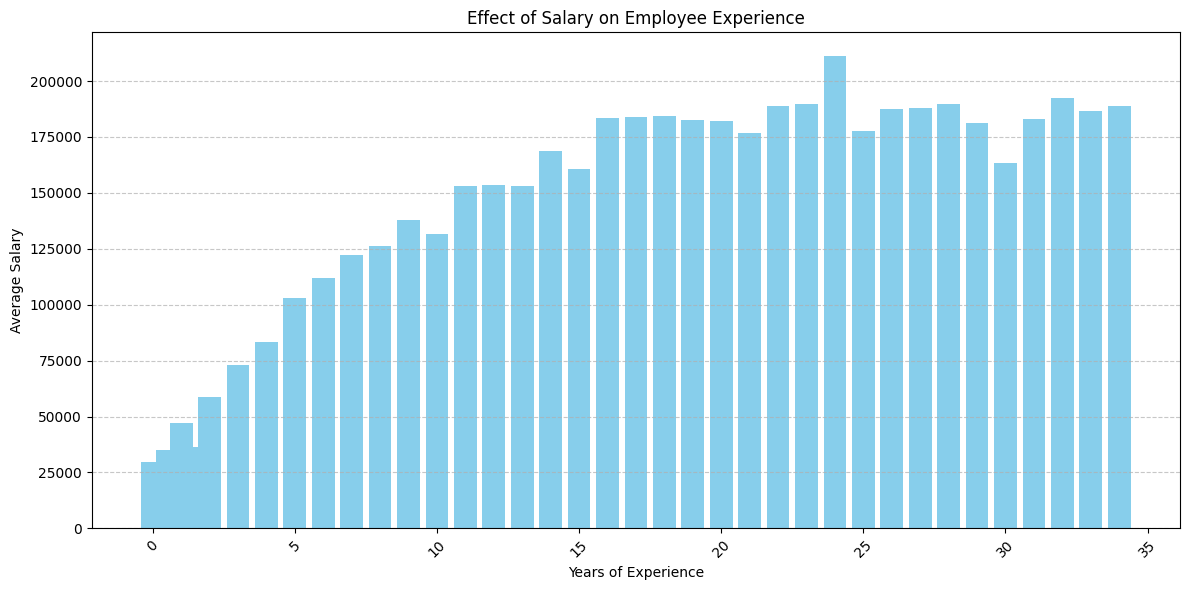

In [57]:
# Main execution
if __name__ == "__main__":
    test_queries = [
        "What are the number of employees doing data scientist job?",
        "Draw a bar chart showing the effect of salary on employee experience",
        #"Forecast salary trends for the next 2 years",
        "Summarize the key findings about our employee data"
    ]
    
    for query in test_queries:
        print(f"\nProcessing query: {query}")
        result = run_agent_workflow(query)
        print(f"Result: {result}")
        print("="*50)